Back in 2013, housing.com was exactly what I wanted - an easy to navigate, color-coded rental map of places. I could consume more information without having to trawl through tiring listing after listing (which was exactly what almost all other websites offered).

(I loved them for putting out exactly what I had in mind and I also remember congratulating myself for having their vision!)

Fast forwarding to 2017, the same guy who was looking for renting places is now looking for a home to purchase. Alas, housing.com has gone back to being a decorative listing place (no surprise there). 

There was no way he was going to filter-search-trawl-and-repeat to get to a place. The road forked; it was going to be either - approach a middle-man or scrape this data. I chose the latter.

![old is gold](http://www.geekycube.com/wp-content/uploads/housing-maps.png)
<small> source: http://www.geekycube.com/wp-content/uploads/housing-maps.png </small>

## Scraping it!

If you nose around the Network tab in Chrome dev-tools long enough, you will notice the jewel of an API - https://search.housing.com/api/v1/buy/similar-properties?source=web&limit=4&flat_id=

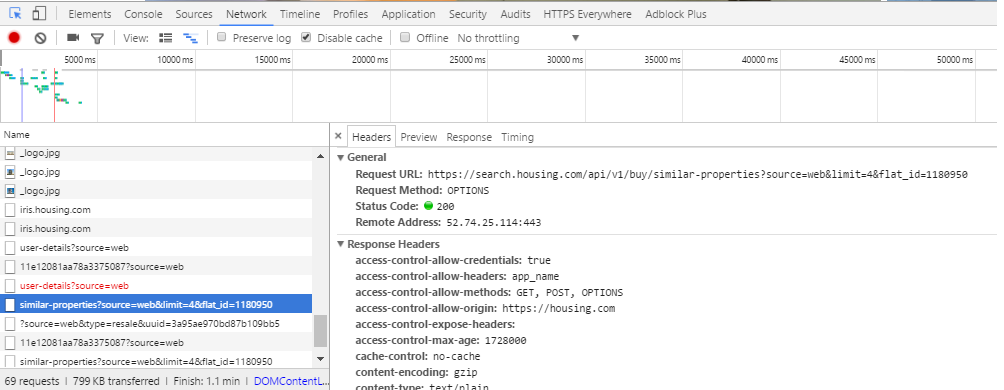

And, this is all you need. The readable naming convention seems to hint that it's their recommendation API. I tried a few combinations and settled down with a _limit=50_. What happened next was pretty simple as you must have guessed - you query this API for a *flat_id* and it would return a JSON response containing a few other flat IDs. You save this data somewhere and repeat the process with each of the new *flat_ids*. And, alas, you have a scraper. 

The scraper in all its uglyness is [here](www.github.com/fx86).

This lazy script got me around 25 thousand listings in a span of a week.

## Can you smell all that data ?!

New Year 2017 resolution: When you have data lying around, visualize it!

And, so we went. I was happy with Pandas and its plotting extensions with a smattering of Seaborn colors schemes and aesthetics for the most part of it.

In [110]:
# The following are my default imports

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [106]:
pd.options.display.mpl_style = False

In [111]:
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

# I wanted to be able to read the long addresses so I increased the column width
pd.set_option('display.max_colwidth', 1000)

Now, that I had imported all the packages that I needed to begin with, I did what all of you would do, with the data.

In [113]:
df = pd.read_csv("housing.csv", encoding="utf-8")
print df.shape

(58551, 227)


The data set initially was 58 thousand rows long and 227 columns wide. This was because there was a lot of overlap; thanks in-part to the nested JSON structure and save duplicates listings.

While the script was humming along, I had pretty-printed it and found some columns of interest.

In [3]:
columns = {"completion_date":"completed_on","ctr":"CTR",
        "date_added":"date_added","date_added_in_seconds":"listing_date_seconds",
        "developer_name":"developer_name","featured_type":"featured_type",
        "impressions":"impressions","inventory_amenities_has_gas_pipeline":"has_gas",
        "inventory_amenities_has_gym":"has_gym","inventory_amenities_has_lift":"has_lift",
        "inventory_amenities_has_parking":"has_parking",
        "inventory_amenities_has_servant_room":"has_servant_room",
        "inventory_amenities_has_swimming_pool":"has_pool",
        "inventory_amenities_is_gated_community":"has_gated_community",
        "inventory_canonical_url":"URL",
        "inventory_configs_0_apartment_type_id":"appt_type_id",
        "inventory_configs_0_area":"area",
        "inventory_configs_0_facing":"facing",
        "inventory_configs_0_is_available":"is_available",
        "inventory_configs_0_number_of_bedrooms":"bedrooms",
        "inventory_configs_0_number_of_toilets":"toilets",
        "inventory_configs_0_parking_count":"parking_count",
        "inventory_configs_0_per_sqft_rate":"sqft_rate",
        "inventory_configs_0_price":"price",
        "inventory_configs_0_property_type_id":"property_type",
        "is_blocked":"is_blocked",
        "is_featured":"is_featured",
        "is_uc_property":"is_uc_property",
        "polygons_hash_city_name":"city",
        "polygons_hash_housing_region_name":"housing_region",
        "polygons_hash_state_name":"state",
        "polygons_hash_sublocality_name":"sub_locality",
        "price_on_request":"price_on_request",
        "show_loan_option":"has_loan",
        "status":"status",
        "street_info":"street",
        "title":"title","type":"sale_type",
        "updated_at":"updated_on",
        "_id": "id",
        "display_neighbourhood_0": "locality"}

Next, I kept the necessary columns and renamed them. 

In [128]:
temp = df[columns.keys()]
temp = temp.rename(columns=columns).drop_duplicates('id')
print temp.shape

(24482, 41)


We have reduced to 41 columns and 24 thousand properties now. 

### Missing values in data

Parental advisory: if your kid comes home with a data set with a long list of columns, do not let them try the following visualization. It may cause dizziness on empty stomach.

But, the same viz helps to see the amount of null values that exist in each column.

In [129]:
df_temp = pd.DataFrame({col: {'Empty': temp[temp[col].isnull()].shape[0], 'Total': temp.shape[0]} for col in temp})

So we made a new data frame, which kept a count of empty cells against non-empty cells. It looked like this:

In [130]:
df_temp.T.head()

,Empty,Total
CTR,0,24482
URL,0,24482
appt_type_id,0,24482
area,0,24482
bedrooms,0,24482


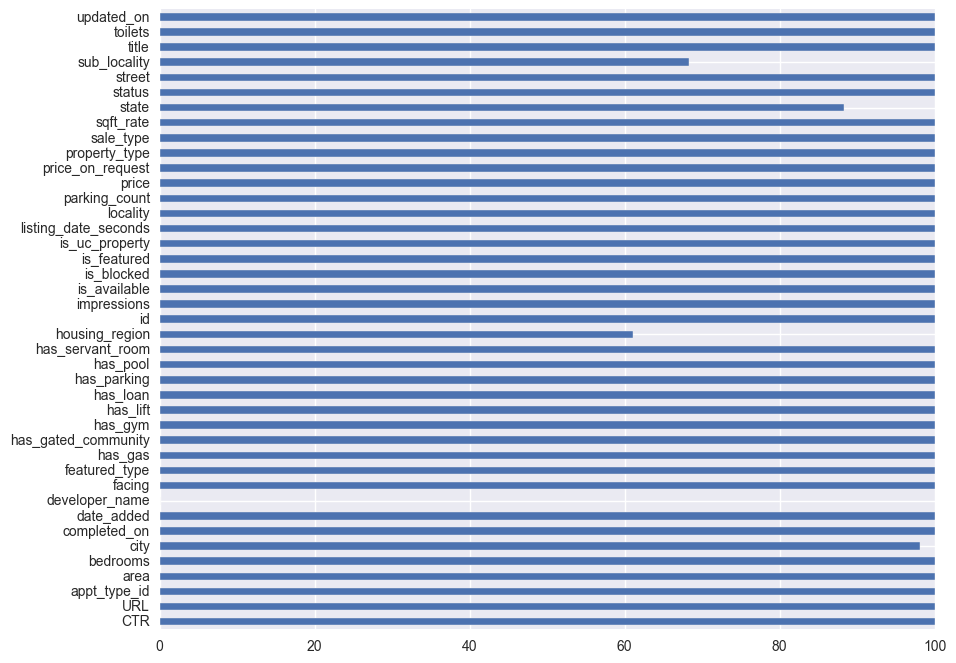

In [131]:
df_temp.apply(lambda v: (v.Total - v.Empty)/float(v.Total) * 100).plot(kind='barh', figsize=(10, 8))

From the above visual we gather that, *developer_name* column is almost empty. Giving it company are, the *sub_locality*, *housing_region* and *locality* columns.


In [7]:
# temp = temp[filter(lambda v: v not in ['sub_locality', 'housing_region', 'locality'], temp.columns)]

In [132]:
# let's drop "status" from the data because it has only one value
print temp.status.unique()
print "dropping status column from temp"
temp = temp.drop('status', 1)

[u'ACTIVE']
dropping status column from temp


### What does the distribution of listings across states look like ?

Maharashtra leads followed by Karnataka and Tamil Nadu.

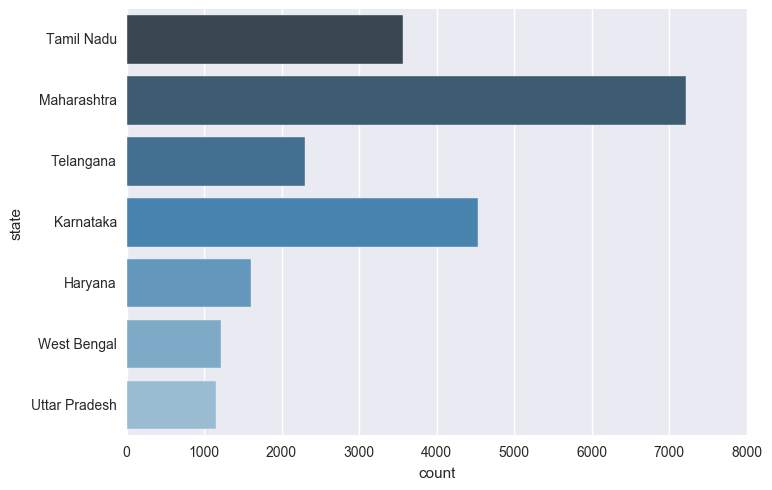

In [133]:
sns.countplot(y="state", data=temp, palette="Blues_d")

### And how about the price distribution ?

Well, in our dataset, Maharashtra seems to be a really pricey state to buy properties in. 

A sizeable chunk of the listings in the state lies between 5-10 crores per piece. No other state seems to come close to Maharashtra's behaviour.

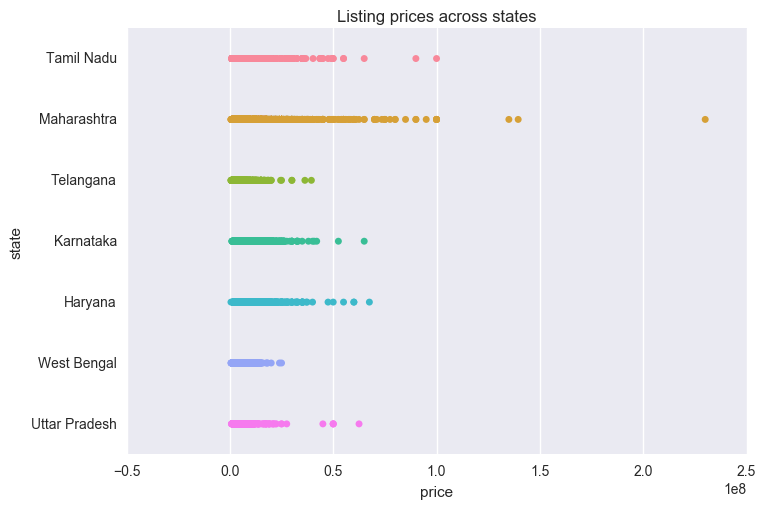

In [134]:
sns.stripplot(temp["price"], temp['state'], order=temp.state.dropna().unique())
plt.title("Listing prices across states")

### What about the metro cities, then ?

A metropolitan area according to the Wikipedia definition is - "The Constitution (seventy-fourth Amendment) Act, 1992 defines a metropolitan area in India as, an area having a population of ten lakhs or more, comprised in one or more districts and consisting of two or more Municipalities or Panchayats or other contiguous areas, specified by the Governor by public notification to be a Metropolitan area." [Source](https://en.wikipedia.org/wiki/List_of_metropolitan_areas_in_India)

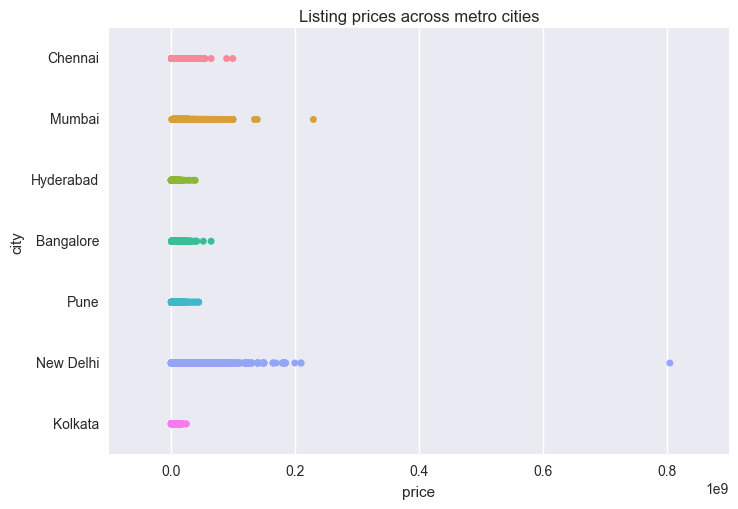

In [140]:
metros = ['New Delhi',
'Mumbai', 
'Kolkata',
'Bangalore', 
'Pune',
'Hyderabad',
'Chennai',
'Surat',
'Visakhapatnam',
'Kanpur']

metro_data = temp[temp.city.isin(metros)]
sns.stripplot(metro_data["price"], metro_data['city'], order=metro_data.city.dropna().unique())
plt.title("Listing prices across metro cities")

Apparently, Mumbai lags behind New Delhi in prices. Though it would be interesting to track down for Maharashtra's price lead as a state, but we will take a raincheck on it. Remember, we are house hunting in Delhi because yours-truly resides there.

housing.com also provides a column called *appt_type_id*. This may provide insight to the *appt_type_id* we should be looking at.

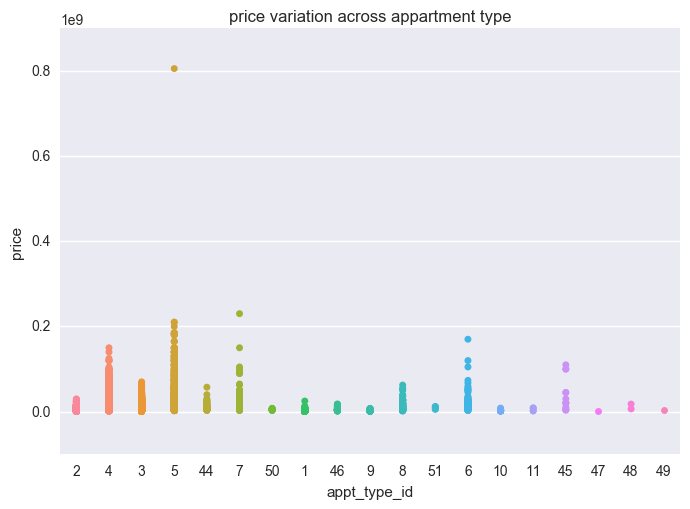

In [11]:
sns.stripplot(temp['appt_type_id'], temp["price"],  order=temp['appt_type_id'].dropna().unique())
plt.title("price variation across appartment type")

Appartment types - 4, 5, 6, 7, 45 - seems to show a broad range of prices than the rest.

### Correlations

Some obvious learnings : 
- More bedrooms usually means more toilets.
- Price has an inclination to rise linearly with area.
- Area in sq ft though does not rise linearly beyond a certain limit.

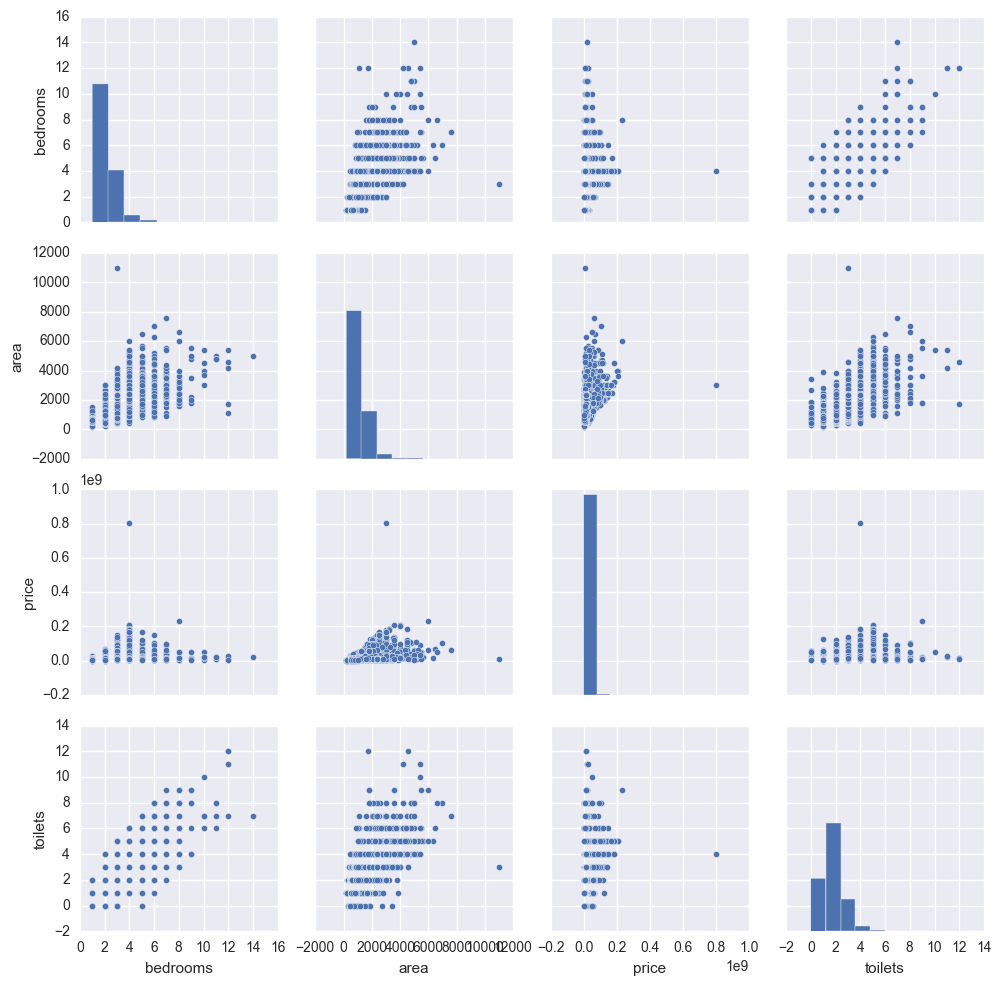

In [142]:
features = ['bedrooms', 'area', 'price', 'toilets']
df_temp = temp[features].stack().unstack()
sns.pairplot(df_temp)

To bring out the correlations more sharply, let's create a heatmap

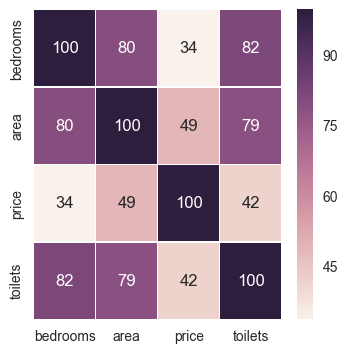

In [148]:
fig, ax = plt.subplots(figsize=(4, 4))
features = ['bedrooms', 'area', 'price', 'toilets']
sns.heatmap((temp[features].corr() * 100).applymap(int), annot=True, fmt="d", ax=ax, linewidth=.4)

Alright, so which of the ammenities affect the housing prices much ?

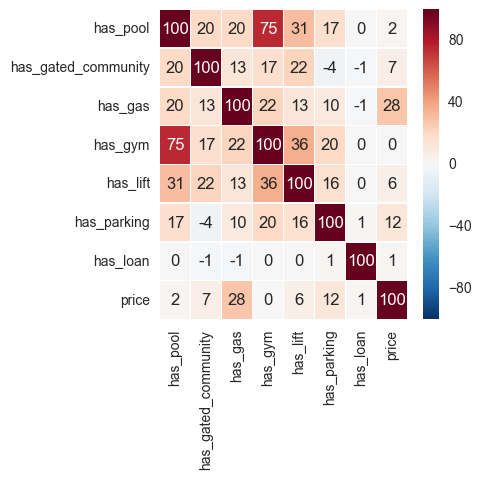

In [180]:
df_temp = temp[['has_pool', 'has_gated_community', 'has_gas', u'has_gym', u'has_lift', 'has_parking', 'has_loan']].astype(int)
df_temp['price'] = temp['price']
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap((df_temp.corr() * 100).applymap(int), annot=True, fmt="d", ax=ax, linewidth=.4)

Wow, it seems price has the most correlation with the availability of gas.
I always assumed, having a pool makes things pricier. Let's see if this holds true for a land-locked city like New Delhi.

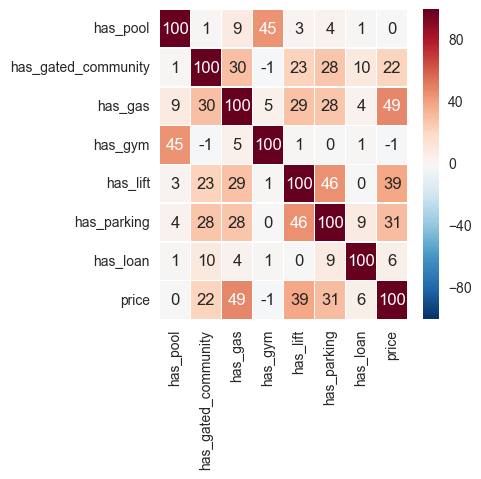

In [184]:
df_temp = temp[temp.city.isin(['New Delhi'])].fillna(0)
ammenities = ['has_pool', 'has_gated_community', 'has_gas', u'has_gym', u'has_lift', 'has_parking', 'has_loan', 'price']
df_temp = df_temp[ammenities].astype(int)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap((df_temp.corr() * 100).applymap(int), annot=True,  fmt="d", ax=ax, linewidth=.4)

As we see above, the factors affecting price are the availability of gas, a lift, a parking space and to some extent a gated community. 

After speaking to a half a dozen real estate agents on the ground, I've learnt that parking can add few lakhs more to the final price. So it may be that in a larger and more representative data set, availability of a parking space will most likely have a higher correlation than that of a lift.

### The cheapest 2/3 BHK in New Delhi ?

Let's look at only the 2,3 and 4 bedroom houses in Delhi which are priced at less than 10 million INR and which are greater than 700 sq ft of space. The last filter removes takes us to the less busy and less pricey parts of the city.

In [185]:
city_wise = temp[(temp.city == 'New Delhi') & (temp.bedrooms.isin([2, 3, 4])) & (temp.price < 10**7) & (temp.area >= 700)]

A single metric was needed which would help find houses with a more complete set of ammenities, like a parking space, a lift, a networked gas connection etc. Hence, we took out these columns and converted them to integer format so that they could be summed up.

In [186]:
boolean_columns = ['has_pool', 'has_gated_community', 'has_gas', u'has_gym', u'has_lift', 'has_parking', 'has_loan']
city_wise.loc[:, boolean_columns] = city_wise[boolean_columns].astype(int)

Below we sum them up to create a *living_index*.

In [187]:
# create a living index. 
city_wise.loc[:, ('living_index')] = city_wise[boolean_columns].sum(axis=1)

Then, we borrow a red-yellow-green color pallette and scale it to the living index; such that higher living-index would appear green-er and a lower one would appear red-der.

In [188]:
living_indices = city_wise.living_index.sort_values().unique()
# creating a color pallette
colors = sns.color_palette("RdYlGn", len(living_indices)).as_hex()
colors = dict(zip(living_indices, colors))

# creating a living index
city_wise.loc[:, ('color')] = city_wise['living_index'].apply(lambda v: colors[v])

# filling in the empty values
city_wise = city_wise.fillna('')

Bokeh charts provide many interesting options for interactive charts within the Jupyter notebook. 

Using the above data, we will use the code below to embed an interactive scatterplot. 
The color used is the *living index* that we had calculated above.
Mousing over the circles will give us further detail of the property. 

Go ahead and explore it!

In [200]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, ResizeTool, PanTool

source = ColumnDataSource(
        data=dict(
            price=city_wise['price'] / 10**5,
            area=city_wise['area'],
            bedrooms=city_wise['bedrooms'],
            street=city_wise['street'],
            locality=city_wise['locality'] + ', ' + city_wise['housing_region'],
            parking=city_wise['has_parking'],
            gated=city_wise['has_gated_community'],
            gas=city_wise['has_gas'], 
            lift=city_wise['has_lift'],
            loan=city_wise['has_loan'],
            color=city_wise['color'],
            living_index=city_wise['living_index'],
            radius=city_wise['bedrooms']*4
        )
    )

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 12px;">Bedrooms: @bedrooms</span><br>
                <span style="font-size: 12px;">Street: @street</span><br>
                <span style="font-size: 12px;">Locality: @locality</span><br>
                <span style="font-size: 12px;">Parking: @parking</span><br>
                <span style="font-size: 12px;">Loan: @loan</span><br>
                <span style="font-size: 12px;">Gated: @gated</span><br>
                <span style="font-size: 12px;">Gas: @gas</span><br>
                <span style="font-size: 12px;">Lift: @lift</span><br>
            </div>
        </div>
        """
    )

p = figure(plot_width=800, plot_height=600, tools=[hover, BoxZoomTool(), ResetTool(), ResizeTool(), PanTool()],
           title="{:s} vs {:s}  Legend: {:s}".format('Number of bedrooms', 'price', 'living index'),
           x_axis_label='Area in sq ft', 
           y_axis_label='Price in Lakhs (or .1 Mn)')

p.circle('area', 'price', source=source, color='color', size='radius', legend='living_index')
p.legend.location = "bottom_right"
# p.legend.click_policy="hide"
output_notebook()
show(p, notebook_handle=True)

Loading BokehJS ...

Further :
- it would be nice idea to let the user (me) click on a circle to directly open the listing without having to open the browser. Bokeh 0.15 has a bug with JSON parsing, which I need to get to fixing or wait for the 0.16 version.
- The street addresses in the data set could give information about banks, ATMs, hospitals and malls, which could be used to further understand the price.
- For places with widespread metro services like Delhi, Gurgaon and Noida, distance to the nearest metro station could be a prime deciding factor in price hike. 

We will explore these in the next blog where we will apply some machine learning to learn more about the data.
Till then, happy house hunting to me.